In [1]:
import argparse
from PIL import Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import cv2
import itertools

* https://arxiv.org/pdf/1702.05931v2.pdf
* https://openreview.net/pdf?id=SkjdxkhoG

In [6]:
import pylab 

def show_images(images, cols = 1, titles = None, save_fig = "default"):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    #fig.set_title("Samples of infected red blood cells")
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.axis("off")
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.savefig('{}'.format(save_fig), dpi=10)
    plt.show()

In [3]:
def stain_norm(img, saveFile=None, Io=240, alpha=1, beta=0.15):
    ''' Normalize staining appearence of H&E stained images
    
    Example use:
        see test.py
        
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
        
    Output:
        Inorm: normalized image
        H: hematoxylin image
        E: eosin image
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    maxCRef = np.array([1.9705, 1.0308])
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    rimg = np.reshape(img.astype(np.float), (-1,3))
    
    # calculate optical density
    OD = -np.log((rimg+1)/Io)
    
    # remove transparent pixels
    ODhat = np.array([i for i in OD if not any(i<beta)])
        
    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    #eigvecs *= -1
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    C2 = np.array([C[:,i]/maxC*maxCRef for i in range(C.shape[1])]).T
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # unmix hematoxylin and eosin
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    
    return Inorm, H, E

In [4]:
x_test = np.load("x_test.npy")
x_test.shape

(2756, 200, 200, 3)

In [18]:
a = 500
b = a + 20

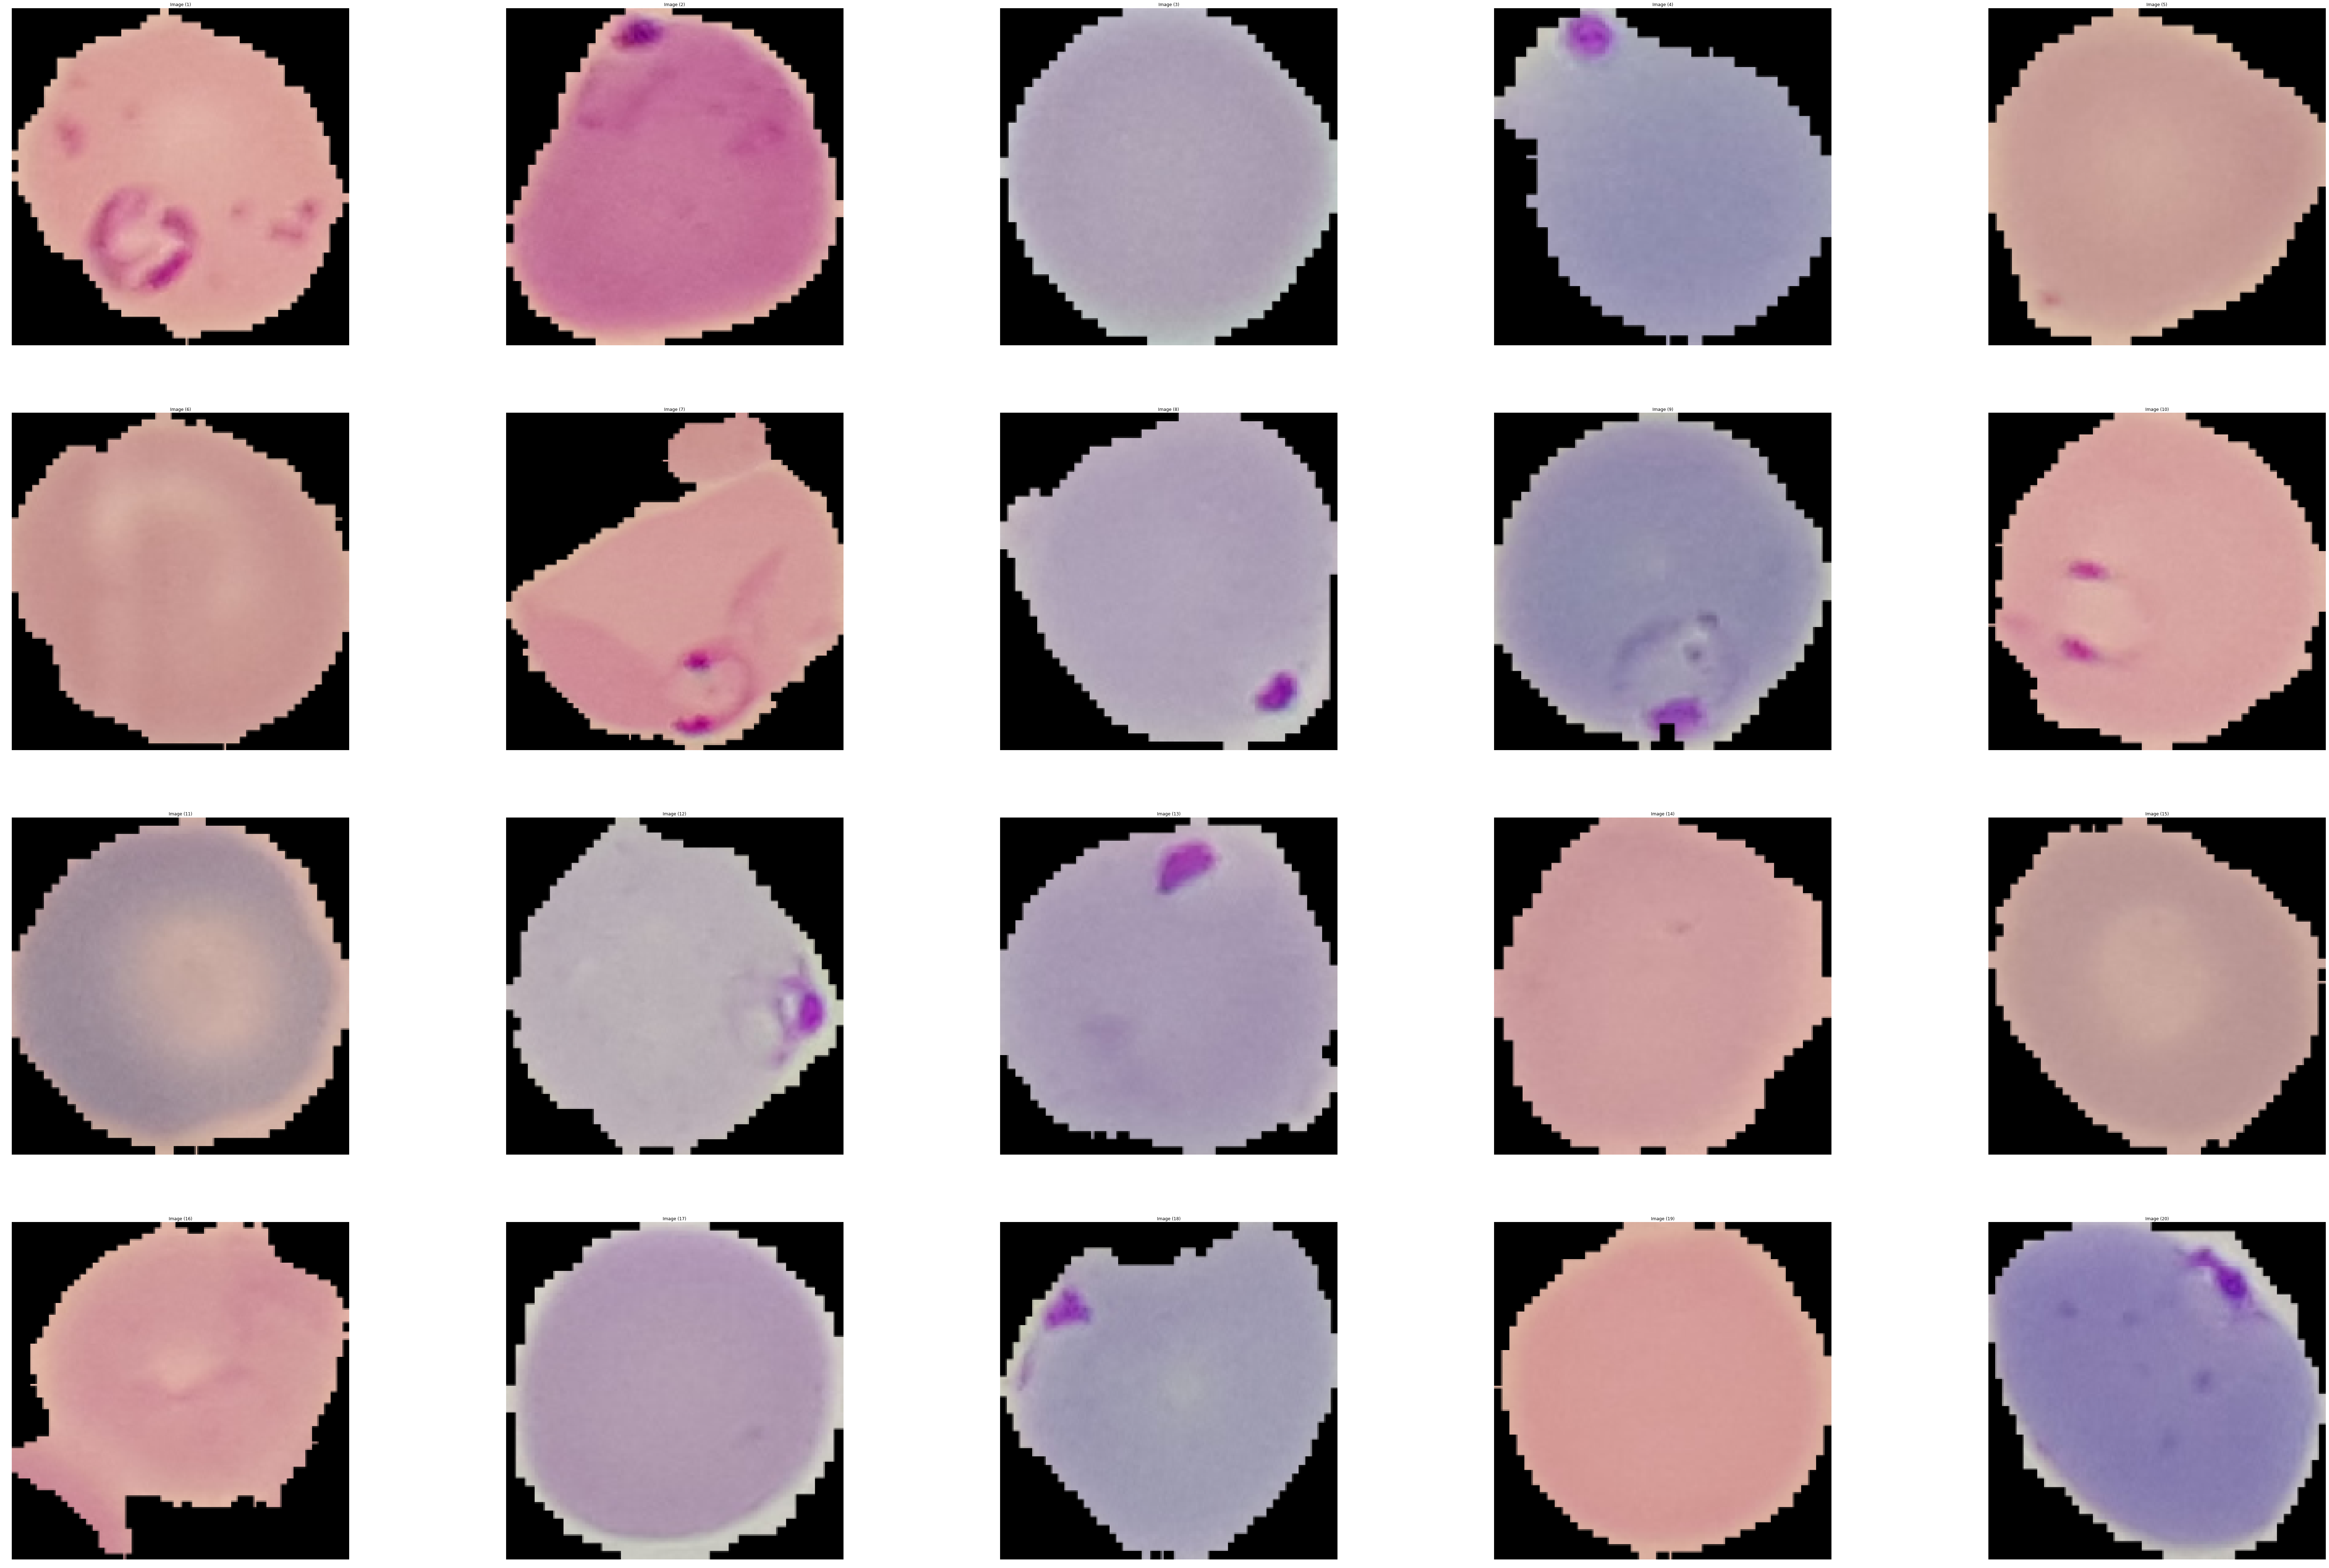

In [19]:
show_images(x_test[a:b], cols = 4, titles = None, save_fig="before_stain_norm")

In [8]:
x_test_stain_norm = []

for img in x_test[:]:
    img_stain, _, _ = stain_norm(img, Io=240, alpha=1, beta=0.15)
    x_test_stain_norm.append(img_stain)

x_test_stain_norm = np.array(x_test_stain_norm)
x_test_stain_norm.shape

(2756, 200, 200, 3)

In [9]:
np.save("x_test_stain_norm.npy", x_test_stain_norm)

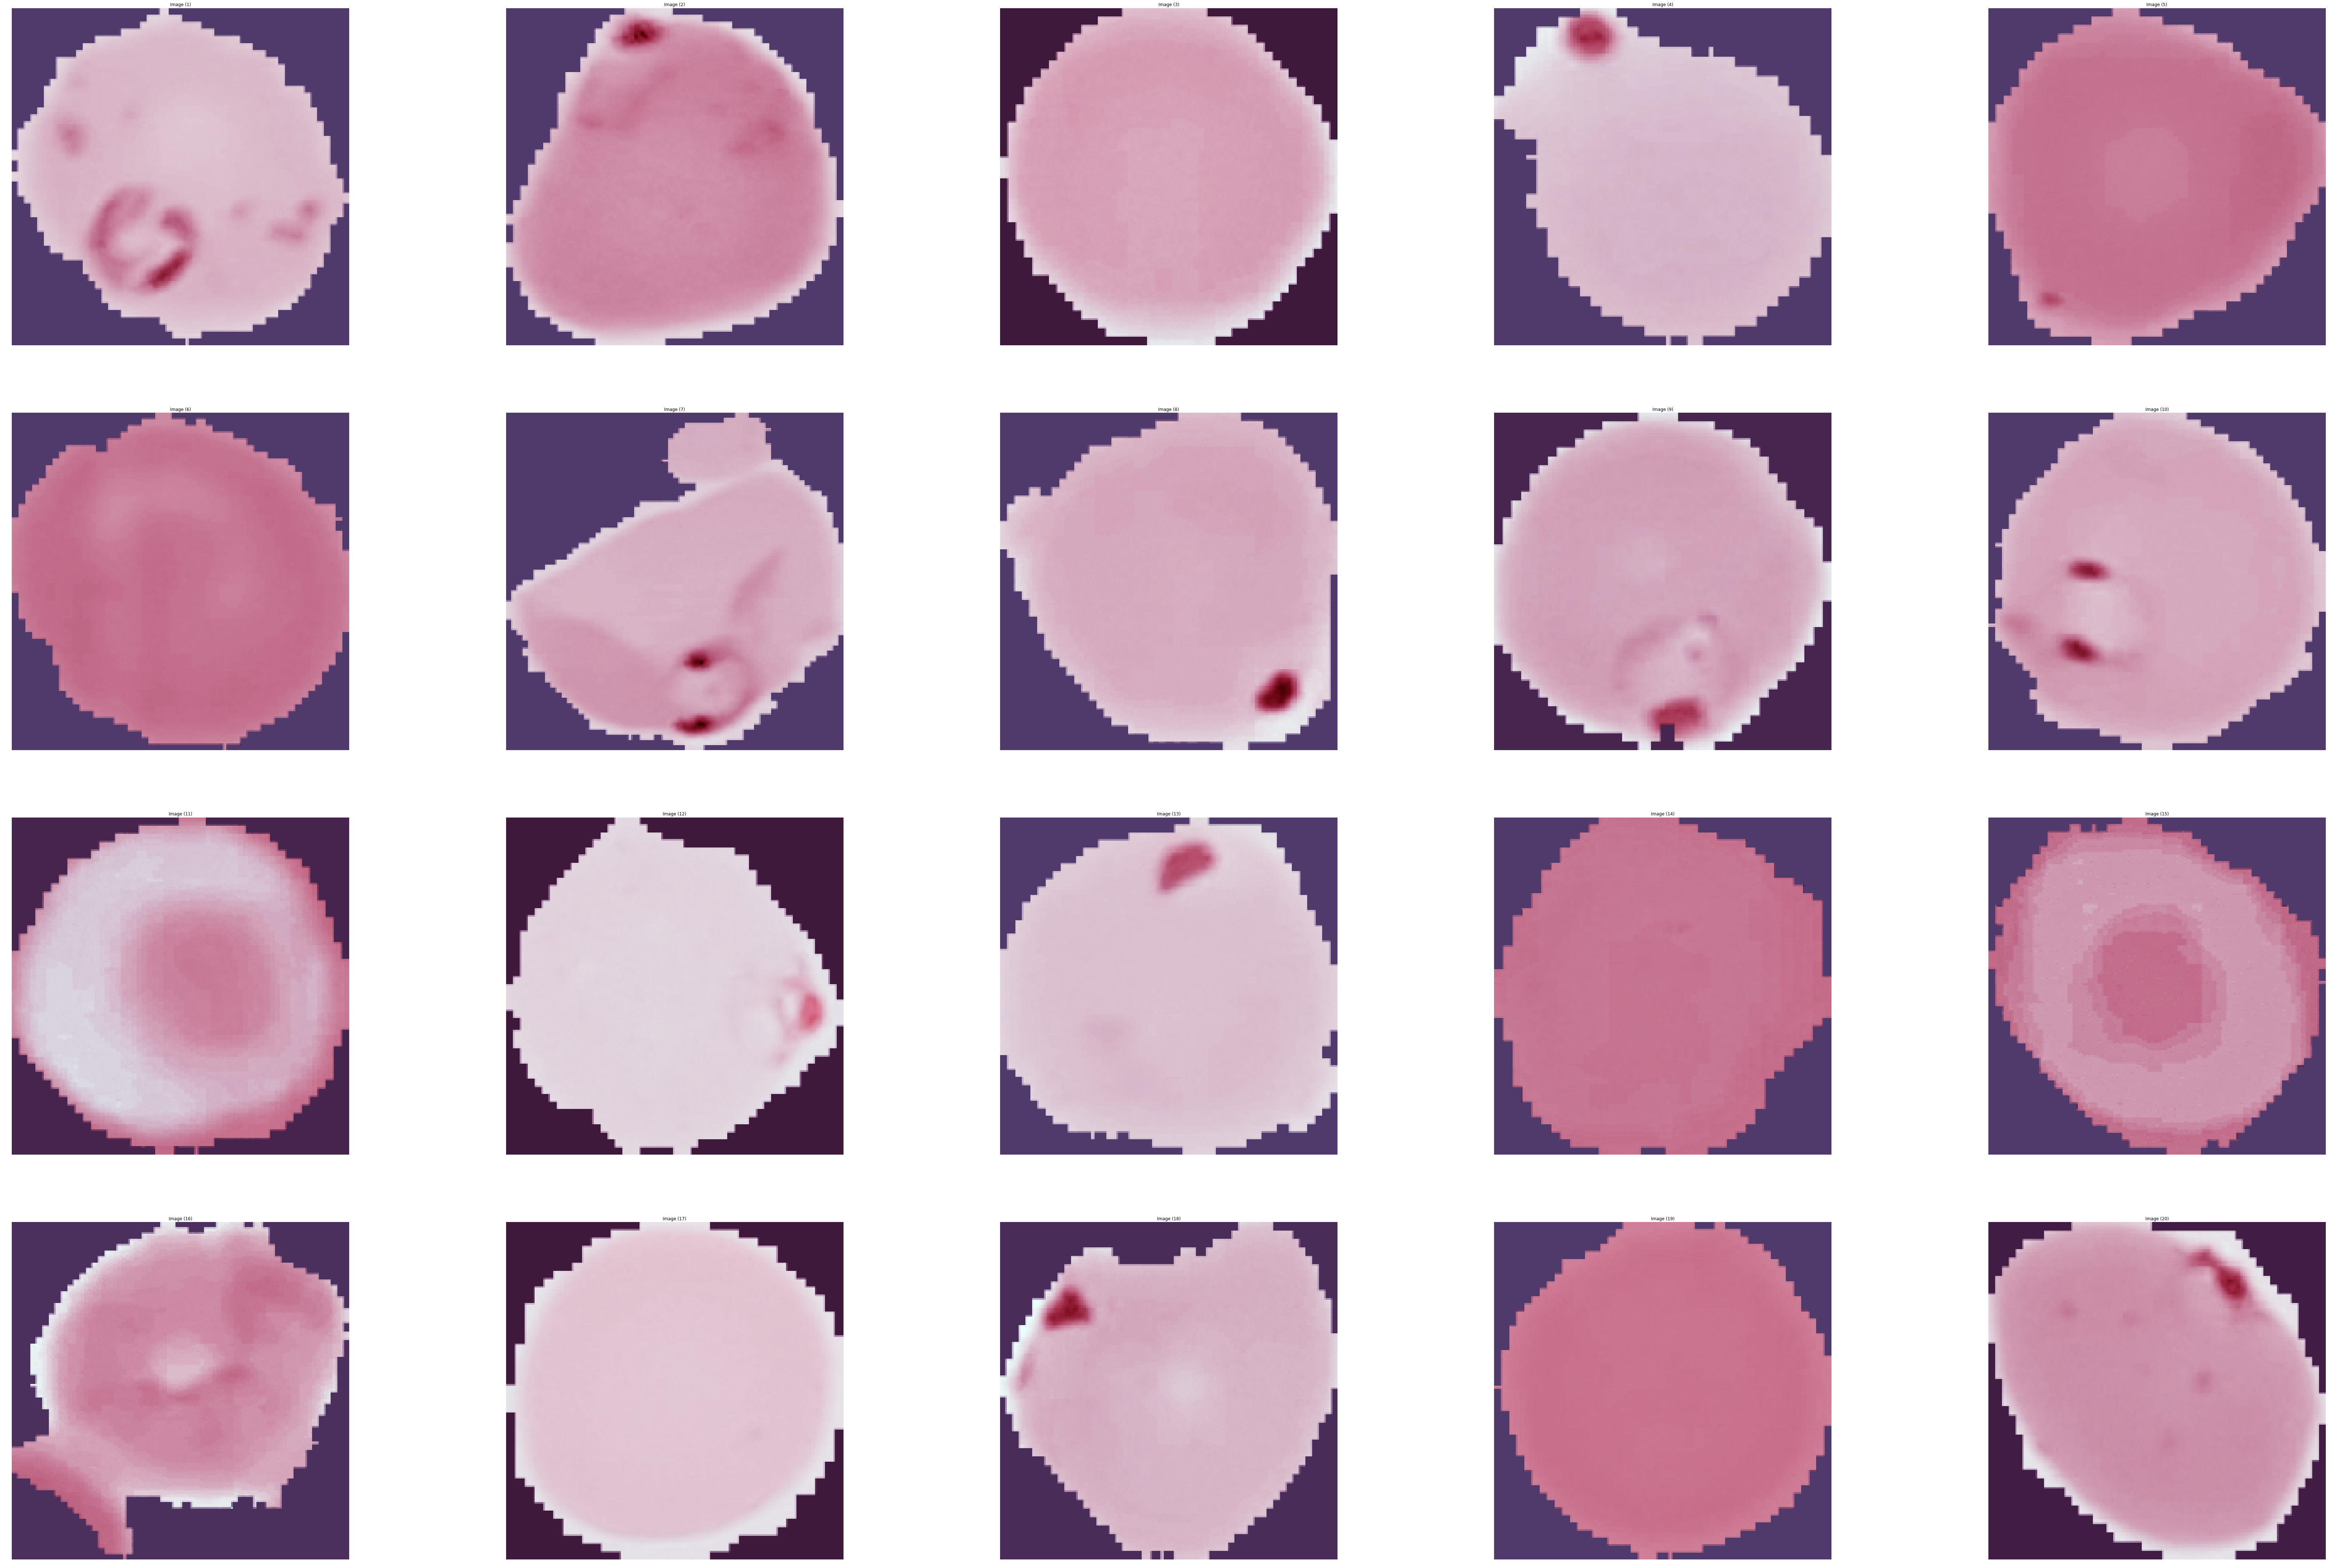

In [20]:
show_images(x_test_stain_norm[a:b], cols = 4, titles = None, save_fig="after_stain_norm")